<a href="https://colab.research.google.com/github/varJATIN/Ocular-fundus-image-Analysis/blob/main/DME_late_fuse_focal_loss_ex_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import sys
import random
import IPython

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

import tensorflow as tf
from tensorflow import keras

from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix,confusion_matrix

from matplotlib.pyplot import imread
from cv2 import resize

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
#import pydot
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow


In [3]:
#tf.__version__,tf. config. list_physical_devices()
!pip install focal-loss

## Read, Split train_val & oversample train set


In [25]:
#ben 10 folder has file1 csv which has dme grades
dataset_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed 512_Size Images/file1.csv"
#images are from sigma 8 folder
dataset_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/ Ben_Processed 512_Size sigma8"
df = pd.read_csv(dataset_groundtruth_location)
img_loc=[]
for i in range(516):
  img_loc.append(dataset_images_location+'/'+str(i)+'.jpg')
df['processed_img_loc'] = img_loc
#print(df[:5][['processed_img_loc','Risk of macular edema ']])
test_df=df[-103:].reset_index(drop=True)[['processed_img_loc','Risk of macular edema ']]
df=df[0:413].reset_index(drop=True)[['processed_img_loc','Risk of macular edema ']]
train_df=shuffle(df)
train_df.head()

,processed_img_loc,Risk of macular edema
160,/content/drive/My Drive/IDRid/B. Disease Gradi...,0
120,/content/drive/My Drive/IDRid/B. Disease Gradi...,2
183,/content/drive/My Drive/IDRid/B. Disease Gradi...,0
318,/content/drive/My Drive/IDRid/B. Disease Gradi...,2
245,/content/drive/My Drive/IDRid/B. Disease Gradi...,2


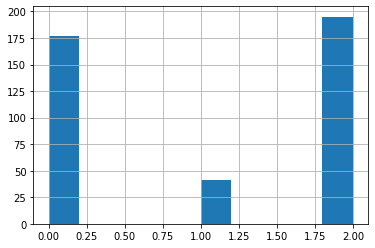

In [26]:
train_df['Risk of macular edema '].hist()

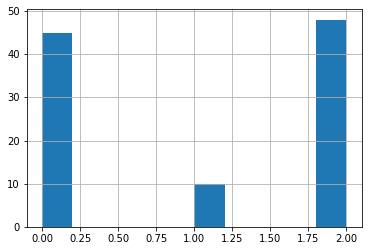

In [27]:
test_df['Risk of macular edema '].hist()

In [90]:
BATCH_SIZE = 4
IMG_WIDTH, IMG_HEIGHT=512,512

configs=dict( rescale=1/255.0,
              rotation_range=30,
              horizontal_flip=True,
              vertical_flip=True,
              zoom_range=[0.85,.98],
              width_shift_range=1.1,
              height_shift_range=0.05,
              fill_mode='nearest')
# Add Image augmentation to our generator
train_datagen = ImageDataGenerator(**configs,validation_split=0.1)
# Use the dataframe to define train and validation generators
train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    x_col='processed_img_loc', 
                                                    y_col='Risk of macular edema ',
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    subset='training',
                                                    class_mode='raw',
                                                    batch_size=BATCH_SIZE)
#val_datagen = ImageDataGenerator(**configs)
                                
val_generator = train_datagen.flow_from_dataframe(  train_df, 
                                                  x_col='processed_img_loc', 
                                                  y_col='Risk of macular edema ',
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  subset='validation',
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='raw'
                                                  )

Found 372 validated image filenames.
Found 41 validated image filenames.


In [91]:
test_image_names = [];
test_image_names = test_df['processed_img_loc'];
print("len of test set ",len(test_image_names))
im_size = 512;

test_labels = [];
test_labels = test_df['Risk of macular edema '];

test_images = np.zeros((103,512,512,3))
ind=0
for image_name in test_image_names:
    test_images[ind] = imread(image_name)
    ind+=1
test_images = test_images /255.0
test_labels = np.array(test_labels, ndmin = 2)
test_labels = np.transpose(test_labels)


print(test_images.shape)
print(test_labels.shape) 

len of test set  103
(103, 512, 512, 3)
(103, 1)


In [92]:
test_datagen = ImageDataGenerator(**configs)
test_generator = test_datagen.flow_from_dataframe(test_df, 
                                                  x_col='processed_img_loc', 
                                                  y_col='Risk of macular edema ',
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=4,
                                                  class_mode='raw'
                                                  )

Found 103 validated image filenames.


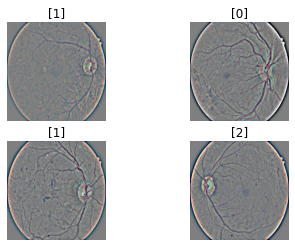

In [93]:
for i in range(4):
  ax=plt.subplot(2,2,i+1)
  plt.imshow(test_images[2*i+1])
  plt.title("{}".format(test_labels[2*i+1])) 
  plt.axis('off')

1.0


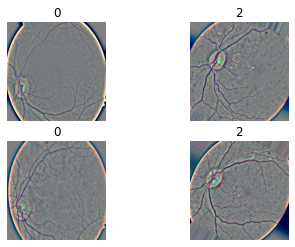

In [94]:
for i,(img,lbl) in enumerate(train_generator):
  print(np.max(img))
  for j in range(4):
    ax=plt.subplot(2,2,j+1)  
    plt.imshow(img[j])
    plt.title("{}".format((lbl[j]))) 
    plt.axis('off')
  break

In [95]:
from keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB4
from keras.models import Model

## Load Segmentation model 


In [96]:
from tensorflow.keras.models import model_from_json
def load_seg_model(model_name):
    # # load json and create model
    json_file = open('/content/drive/MyDrive/IDRid/Experimental models/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    # # load weights into new model
    loaded_model.load_weights("/content/drive/MyDrive/IDRid/Experimental models/{}.h5".format(model_name))
    # # evaluate loaded model on test data
    loaded_model.compile()
    print(model_name," Model loaded and compiled")
    return loaded_model

In [97]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    # Retrieve Filters
    F1, F2, F3 = filters
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
  
    return X

def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
  
    # Save the input value
    X_shortcut = X
    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path 
    X = Conv2D(F2, (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer=glorot_uniform(seed =0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu') (X)

    # Third component of main path 
    X = Conv2D(F3, (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer=glorot_uniform(seed =0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(F3, (1,1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer=glorot_uniform(seed =0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X


In [110]:
def build_model(num_classes,model_name):
    IMG_SIZE=512
    NUM_CLASSES=num_classes
    # define inputs
    input_0 =layers.Input(shape=(512,512, 3))
    input_1=tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE,  name='resize_input')(input_0)
    if model_name=='DenseNet121':
      base_model = DenseNet121(include_top=False, input_tensor=input_1, weights="imagenet")
    elif model_name=='EfficientNetB4':
      base_model = EfficientNetB4(include_top=False, input_tensor=input_1*255, weights="imagenet")
    ex_model=load_seg_model("seg_EX_ben_sigm8_5l_3f")
    #se_model=load_seg_model("seg_SE_ben_sigm8_4l_4f")
    #he_model=load_seg_model("seg_HE_ben_sigm8_6l_4f")
    # Freeze the pretrained weights
    base_model.trainable = False
    ex_model.trainable=False
    #se_model.trainable=False
    #he_model.trainable=False
    ex_model._name='model_ex'
    #se_model._name='model_se'
    #he_model._name='model_he'
    #pass image for lesion
    les_ex=ex_model(input_0)
    #les_se=se_model(input_0)
    #les_he=he_model(input_0)

    #attention based input
    #att=layers.Concatenate(name='concat_lesion')([les_ex,les_se,les_he])
    W_g=keras.layers.Conv2D(6, kernel_size=1, padding='same', strides=1,name='Wg')(les_ex)
    W_g=tf.keras.layers.BatchNormalization()(W_g)
    #input image
    W_x=keras.layers.Conv2D(6, kernel_size=1, padding='same', strides=1,name='Wx')(input_0)
    W_x=tf.keras.layers.BatchNormalization()(W_x)
    # convolve to  attention filter
    att=layers.Add(name='additive_enhance_layer')([W_x,W_g])
    att=tf.keras.activations.relu(att, alpha=0.0, max_value=None, threshold=0)
    att=keras.layers.Conv2D(1, kernel_size=1, padding='same', strides=1)(att)
    att=tf.keras.activations.sigmoid(tf.keras.layers.BatchNormalization()(att))
    f_lesions=tf.keras.layers.Multiply()([att,input_0])
    
    #block1
    f_lesions=convolutional_block(f_lesions,3,(3,3,16),1,'a')
    f_lesions=identity_block(f_lesions,3,(3,3,16),1,'b')
    #block2
    f_lesions=convolutional_block(f_lesions,3,(16,16,32),2,'a')
    f_lesions=identity_block(f_lesions,3,(16,16,32),2,'b')
    #block3
    f_lesions=convolutional_block(f_lesions,3,(32,32,64),3,'a')
    f_lesions=identity_block(f_lesions,3,(32,32,64),3,'b')
    #block 4
    f_lesions=convolutional_block(f_lesions,3,(64,64,128),4,'a')
    f_lesions=identity_block(f_lesions,3,(64,64,128),4,'b')
    f_lesions=identity_block(f_lesions,3,(64,64,128),4,'c')
    
    #block 5
    f_lesions=convolutional_block(f_lesions,3,(128,128,256),5,'a')
    f_lesions=identity_block(f_lesions,3,(128,128,256),5,'b')
    f_lesions=identity_block(f_lesions,3,(128,128,256),5,'c')
    
    #pooling
    f_lesions=layers.GlobalAveragePooling2D()(f_lesions)
    top_dropout_rate = 0.2
   
    #predection_2
    x=base_model.output
    x=layers.GlobalAveragePooling2D()(x)
    x=layers.Concatenate()([x,f_lesions])
    # Rebuild top
    x = Flatten(name="flatten_2")(x)
    x = Dropout(top_dropout_rate, name="top_dropout_1")(x)
    x = Dense(256, activation="relu", name="last_dense_2")(x)
    x = Dropout(top_dropout_rate, name="top_dropout_2")(x)
    x = Dense(NUM_CLASSES, activation="softmax", name="pred_2")(x)
  
    # Compile
    model = tf.keras.Model(input_0, x, name="Segnet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4,beta_1=0.9)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [111]:
random.seed = 42
tf.seed = 42
tf.random.set_seed(42)
model=build_model(3,'EfficientNetB4')

seg_EX_ben_sigm8_5l_3f  Model loaded and compiled


In [112]:
from keras.utils.layer_utils import count_params
trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)
print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 19,438,195
Trainable params: 1,389,191
Non-trainable params: 18,049,004


In [ ]:
plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=48,
)

In [113]:
random.seed = 42
tf.seed = 42
tf.random.set_seed(42)
from focal_loss import SparseCategoricalFocalLoss
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3,beta_1=0.9)
model.compile(optimizer=optimizer, loss=SparseCategoricalFocalLoss(gamma=3), metrics=["accuracy"])
es = tf.keras.callbacks.EarlyStopping(monitor='accuracy', mode='auto', verbose=1, patience=4)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.5, 
                        patience=4, 
                        verbose=1, 
                        mode='auto',  
                        min_delta=0.01)
hist=model.fit(train_generator,steps_per_epoch=len(train_generator) , 
               epochs =20, callbacks = [es,rlr],validation_data=val_generator,validation_steps=len(val_generator));

Epoch 1/20
93/93 [==============================] - 77s 591ms/step - loss: 0.6797 - accuracy: 0.6051 - val_loss: 0.2158 - val_accuracy: 0.6585
Epoch 2/20
93/93 [==============================] - 50s 530ms/step - loss: 0.1788 - accuracy: 0.7264 - val_loss: 0.2391 - val_accuracy: 0.6829
Epoch 3/20
93/93 [==============================] - 50s 533ms/step - loss: 0.1598 - accuracy: 0.7574 - val_loss: 0.1778 - val_accuracy: 0.7073
Epoch 4/20
93/93 [==============================] - 50s 533ms/step - loss: 0.1745 - accuracy: 0.7783 - val_loss: 0.1882 - val_accuracy: 0.7805
Epoch 5/20
93/93 [==============================] - 50s 539ms/step - loss: 0.1713 - accuracy: 0.7853 - val_loss: 0.1674 - val_accuracy: 0.7561
Epoch 6/20
93/93 [==============================] - 50s 537ms/step - loss: 0.1532 - accuracy: 0.8081 - val_loss: 0.1750 - val_accuracy: 0.6829
Epoch 7/20
93/93 [==============================] - 50s 533ms/step - loss: 0.1268 - accuracy: 0.8223 - val_loss: 0.1627 - val_accuracy: 0.7561

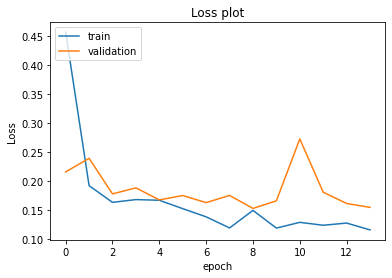

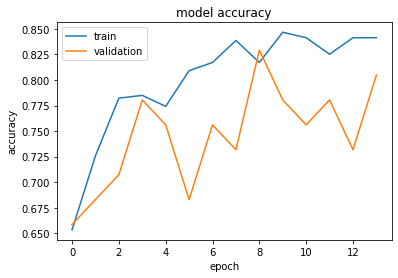

In [114]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("Loss plot")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [115]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_score,accuracy_score
def quadratic_kappa(y_hat, y):
    return cohen_kappa_score(y_hat, y, weights='quadratic')

In [116]:
pred_y_=np.zeros((len(val_generator)*4,3))
val_y_=np.zeros((len(val_generator)*4,1))
for i,(img,lbl) in enumerate(val_generator):
  pred_y_[4*i:4*i+4]=model.predict(img)
  val_y_[4*i:4*i+4,0]=lbl
  # run for loop len(val_generator) as it will cover all the images in test data i.e. last batch will be of 3 images
  if i==len(val_generator)-1:
    break
pred_y_=pred_y_
cm=confusion_matrix(val_y_,np.argmax(pred_y_,axis=1))
print(cm)
#plt.imshow(cm, cmap='binary')
#print(" precision_score ",precision_score(np.argmax(val_y_,axis=1),np.argmax(pred_y_,axis=1))," precision")
print("accuracy ",accuracy_score(val_y_,np.argmax(pred_y_,axis=1))," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_,axis=1),(val_y_)))

[[21  0  1]
 [ 3  0  3]
 [ 2  0 14]]
accuracy  0.7954545454545454  accuracy
quadratic kappa  0.7744874715261959


In [117]:
pred_y_=np.zeros((test_labels.shape[0],3))
for i in range(26):
  pred_y_[4*i:4*i+4]=model.predict(test_images[4*i:4*i+4])
cm=confusion_matrix(test_labels,np.argmax(pred_y_,axis=1))
print(cm)
score=accuracy_score(test_labels,np.argmax(pred_y_,axis=1))
print(score," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_,axis=1),(test_labels)))

[[43  1  1]
 [ 4  4  2]
 [15  5 28]]
0.7281553398058253  accuracy
quadratic kappa  0.5953267162944582


## acc with TTA

In [118]:
pred_y_tta=np.zeros((103,3))
test_y_=np.zeros((103,1))
for i,(img,lbl) in enumerate(test_generator):
  #print(img.shape,lbl.shape)
  pred_y_tta[4*i:4*i+4]=model.predict(img)
  test_y_[4*i:4*i+4,0]=lbl
  if i==25:
    break
cm=confusion_matrix(test_y_,np.argmax(pred_y_tta,axis=1))
print(cm)
#plt.imshow(cm, cmap='binary')
score=accuracy_score(test_y_,np.argmax(pred_y_tta,axis=1))
print(score," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_tta,axis=1),test_y_))

[[43  0  2]
 [ 4  0  6]
 [ 6  6 36]]
0.7669902912621359  accuracy
quadratic kappa  0.7480635955972279


## unfreeze and train

In [119]:
count=0
model.trainable=True
for layer in model.layers:
  if layer.name[-2:] == 'bn':
    layer.trainable=False
    count+=1
  if layer.name[-2:] in ['he','ex','se' ]:
    layer.trainable=False
    print(layer.name," freezed")
    count+=1
print(count-4," layers of bn freezed+ 4 seg model freezed")
trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)
print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

model_ex  freezed
93  layers of bn freezed+ 4 seg model freezed
Total params: 19,438,195
Trainable params: 18,812,607
Non-trainable params: 625,588


In [120]:
# Use the dataframe to define train and validation generators
train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    x_col='processed_img_loc', 
                                                    y_col='Risk of macular edema ',
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    subset='training',
                                                    class_mode='raw',
                                                    batch_size=3)
                                
val_generator = train_datagen.flow_from_dataframe(  train_df, 
                                                  x_col='processed_img_loc', 
                                                  y_col='Risk of macular edema ',
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  subset='validation',
                                                  batch_size=3,
                                                  class_mode='raw'
                                                  )

Found 372 validated image filenames.
Found 41 validated image filenames.


In [121]:
random.seed = 42
tf.seed = 42
tf.random.set_seed(42)
from keras.callbacks import ModelCheckpoint
filepath="weights.{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
opt = keras.optimizers.Adam(learning_rate = 1e-5, beta_1 = 0.9)
model.compile(loss=SparseCategoricalFocalLoss(gamma=3),
              optimizer=opt,
              metrics=['accuracy'])
early_stopping= tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', min_delta = 0.01, patience = 5)
hist1=model.fit(train_generator,steps_per_epoch=len(train_generator) , 
               epochs =8, callbacks = [es,rlr,checkpoint],validation_data=val_generator,validation_steps=len(val_generator));

Epoch 1/8
124/124 [==============================] - 172s 1s/step - loss: 0.1512 - accuracy: 0.7936 - val_loss: 0.1549 - val_accuracy: 0.7805

Epoch 00001: val_accuracy improved from -inf to 0.78049, saving model to weights.01-0.78.hdf5
Epoch 2/8
124/124 [==============================] - 138s 1s/step - loss: 0.0920 - accuracy: 0.8827 - val_loss: 0.1299 - val_accuracy: 0.8537

Epoch 00002: val_accuracy improved from 0.78049 to 0.85366, saving model to weights.02-0.85.hdf5
Epoch 3/8
124/124 [==============================] - 138s 1s/step - loss: 0.0902 - accuracy: 0.8572 - val_loss: 0.2026 - val_accuracy: 0.7317

Epoch 00003: val_accuracy did not improve from 0.85366
Epoch 4/8
124/124 [==============================] - 138s 1s/step - loss: 0.0788 - accuracy: 0.8930 - val_loss: 0.1518 - val_accuracy: 0.7805

Epoch 00004: val_accuracy did not improve from 0.85366
Epoch 5/8
124/124 [==============================] - 138s 1s/step - loss: 0.0865 - accuracy: 0.8814 - val_loss: 0.1650 - val_ac

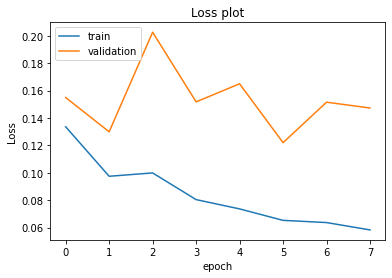

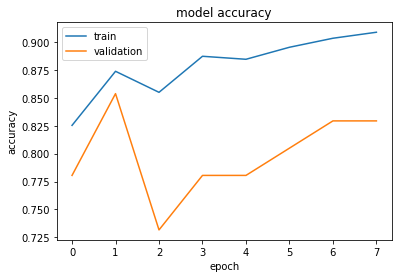

In [122]:
plt.plot(hist1.history["loss"])
plt.plot(hist1.history["val_loss"])
plt.title("Loss plot")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

plt.plot(hist1.history["accuracy"])
plt.plot(hist1.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [123]:
print(" After unfreezing and training")
pred_y_=np.zeros((test_labels.shape[0],3))
for i in range(26):
  pred_y_[4*i:4*i+4]=model.predict(test_images[4*i:4*i+4])
cm=confusion_matrix(test_labels,np.argmax(pred_y_,axis=1))
print(cm)
#plt.imshow(cm, cmap='binary')
score=accuracy_score(test_labels,np.argmax(pred_y_,axis=1))
print(score," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_,axis=1),test_labels))

 After unfreezing and training
[[41  3  1]
 [ 1  6  3]
 [ 5  6 37]]
0.8155339805825242  accuracy
quadratic kappa  0.7959740885486375


In [124]:
print(" After unfreezing and training")
score=0
for j in range(25):
  for i,(img,lbl) in enumerate(test_generator):
    pred_y_tta[4*i:4*i+4]=model.predict(img)
    test_y_[4*i:4*i+4,0]=lbl
    if i==25:
      break
  cm_=confusion_matrix(test_y_,np.argmax(pred_y_tta,axis=1))
  score_=accuracy_score(test_y_,np.argmax(pred_y_tta,axis=1))
  if score_>score:
    score=score_
    cm=cm_
print(cm)
#plt.imshow(cm, cmap='binary')
print(score," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_tta,axis=1),test_y_))

 After unfreezing and training
[[42  1  2]
 [ 1  7  2]
 [ 5  4 39]]
0.8543689320388349  accuracy
quadratic kappa  0.8044097478636987


## save model to disk

In [125]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/My Drive/IDRid/Experimental models/85_ben8_Late_fus_EX_based_atten_dme_focal.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/IDRid/Experimental models/85_ben8_Late_fus_EX_based_atten_dme_focal.h5")
print("Saved model to disk")

Saved model to disk


##attention maps

In [130]:
layers_name=[]
index_att_layer=0
count=0
for i in model.layers:
  layers_name.append(i.name)
  if i.name=='tf.math.sigmoid_3':
    index_att_layer=count
  if i.name=='multiply_3':
    index_filt_layer=count
  count+=1
att=Model(inputs=model.input,outputs=model.layers[index_att_layer].output)
filtered_image=Model(inputs=model.input,outputs=model.layers[index_filt_layer].output) 

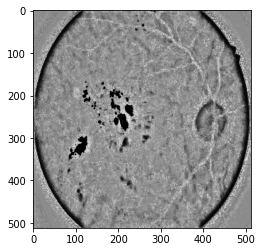

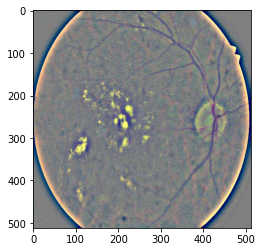

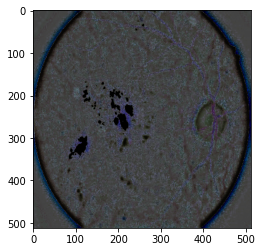

predicted grade : [2]
actual grade : [[2]]


In [136]:
k=14
attention_map=att(test_images[k:k+1,:,:,:])
plt.imshow(attention_map[0,:,:,0],cmap='gray')#/np.max(attention_map))
plt.show()
plt.imshow(test_images[k,:,:,:])
plt.show()
plt.imshow(filtered_image(test_images[k:k+1,:,:,:])[0,:,:,:])
plt.show()
print("predicted grade :",np.argmax(model(test_images[k:k+1,:,:,:]),axis=1))
print("actual grade :",test_labels[k:k+1])

In [138]:
model_1=build_model(3,'EfficientNetB4')
model_1.load_weights("weights.02-0.85.hdf5") 

seg_EX_ben_sigm8_5l_3f  Model loaded and compiled


In [140]:
print(" Best validation")
pred_y_=np.zeros((test_labels.shape[0],3))
for i in range(26):
  pred_y_[4*i:4*i+4]=model_1.predict(test_images[4*i:4*i+4])
cm=confusion_matrix(test_labels,np.argmax(pred_y_,axis=1))
print(cm)
#plt.imshow(cm, cmap='binary')
score=accuracy_score(test_labels,np.argmax(pred_y_,axis=1))
print(score," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_,axis=1),test_labels))

 Best validation
[[41  2  2]
 [ 3  5  2]
 [ 7  5 36]]
0.7961165048543689  accuracy
quadratic kappa  0.7400357555999579
